In [1]:
using Plots
using LightGraphs
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using LaTeXStrings
using Flux
using GraphRecipes
using GraphPlot
using StatsBase
using Distributions
using OneHotArrays
using Statistics
using InvertedIndices
using ROCAnalysis

In [2]:
function randomPopulateMat(mat,symmetric=true)
#     for ii = 1:round(Int, percPopulate*size(mat)[1] )
#         row_tmp = rand( 1:size(mat)[1] )
#         col_tmp = rand( 1:size(mat)[1] )
#         if( row_tmp == col_tmp )
#             col_tmp = rand( deleteat!( collect(1:size(mat)[1]), row_tmp ) )            
#         end
#         mat[row_tmp,col_tmp] = 1
#         if(symmetric == true)
#             mat[col_tmp,row_tmp] = 1
#         end
#     end
    return adjacency_matrix(erdos_renyi( size(mat)[1] , size(mat)[1] ))
end

randomPopulateMat (generic function with 2 methods)

In [3]:
function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end

A2S (generic function with 1 method)

In [4]:
function A2k(SMat,k)
    return SMat^k
end

A2k (generic function with 1 method)

In [5]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 20
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 5

5

In [6]:
benchmarkDicts = Dict()
benchmarkDicts["time"] = []
benchmarkDicts["memory"] = []
benchmarkDicts["gctime"] = []
benchmarkDicts["allocs"] = []
NN = [10^k for k in 1:5] #[10^1,10^2,10^3,10^4,10^5]
percPopulate = 0.1
for ii in 1:length(NN)
    NNtmp = NN[ii]
    AA = spzeros(NNtmp,NNtmp);
    AA = randomPopulateMat(AA);
    bb = @benchmark A2S($AA)
    push!(benchmarkDicts["time"],mean(bb).time)
    push!(benchmarkDicts["memory"],mean(bb).memory)
    push!(benchmarkDicts["gctime"],mean(bb).gctime)
    push!(benchmarkDicts["allocs"],mean(bb).allocs)
    
end

In [7]:
benchmarkDicts["time"]

5-element Vector{Any}:
   1982.3799999999999
  33514.55
 104176.05
      1.38115415e6
      1.24927357e7

In [8]:
benchmarkDicts["memory"]

5-element Vector{Any}:
     3376
    22992
   211120
  2091568
 20901344

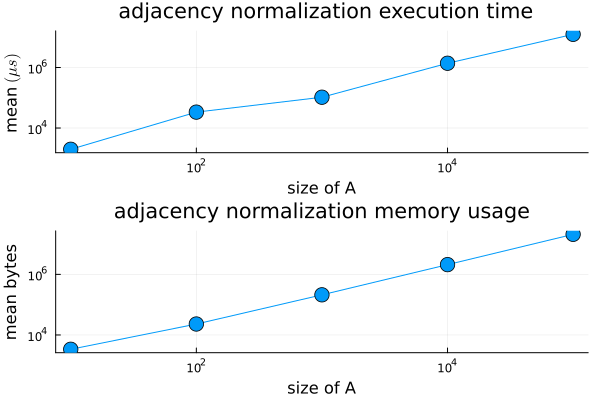

In [9]:
pTime = plot( NN , benchmarkDicts["time"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean " * L"(\mu s)")
title!(" adjacency normalization execution time")
pMemory = plot( NN , benchmarkDicts["memory"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean bytes")
title!("adjacency normalization memory usage")
plot(pTime, pMemory, layout = Plots.grid(2,1) )

In [10]:
benchmarkDicts_k = Dict()
benchmarkDicts_k["time"] = []
benchmarkDicts_k["memory"] = []
benchmarkDicts_k["gctime"] = []
benchmarkDicts_k["allocs"] = []
NN = [10^6]
percPopulate = 0.1
NNtmp = NN[1]
AA = spzeros(NNtmp,NNtmp);
AA = randomPopulateMat(AA);
AS = A2S(AA)
K = [0,1,2,3,4,6]
for ii in 1:length(K)
    kk = K[ii]
    bb = @benchmark A2k(AS,$kk)
    push!(benchmarkDicts_k["time"],mean(bb).time)
    push!(benchmarkDicts_k["memory"],mean(bb).memory)
    push!(benchmarkDicts_k["gctime"],mean(bb).gctime)
    push!(benchmarkDicts_k["allocs"],mean(bb).allocs)
    
end

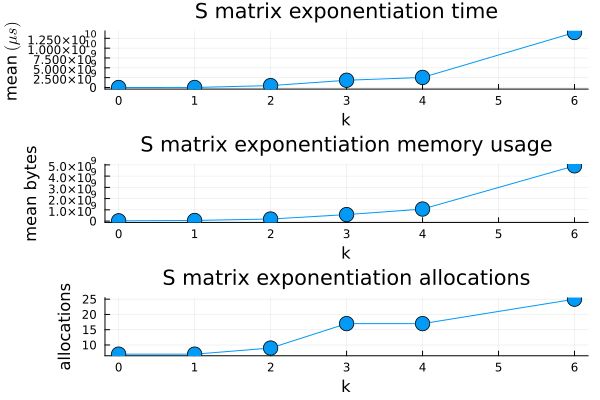

In [11]:
pTime = plot( K , benchmarkDicts_k["time"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean " * L"(\mu s)")
title!("S matrix exponentiation time")
pMemory = plot( K , benchmarkDicts_k["memory"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean bytes")
title!("S matrix exponentiation memory usage")
pAllocs = plot( K , benchmarkDicts_k["allocs"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("allocations")
title!("S matrix exponentiation allocations")
plot(pTime, pMemory, pAllocs, layout = Plots.grid(3,1) )

# generate the block diagonal data to experiment with

In [12]:
nn_max = 4
nn_min = 2
NN_set = [10^n for n in nn_min:nn_max];

In [13]:
ER_BA_SF_WS_Block_graphs = Dict()
ER_BA_SF_WS_Block_matrices = Dict()
for nn in 1:length(NN_set)    
    
    NN_tmp = Int( NN_set[nn] / 4 )
    
    ER_tmp = erdos_renyi( NN_tmp , 10*(NN_tmp) )
    BA_tmp = barabasi_albert( NN_tmp , 8 )
    SF_tmp = static_scale_free( NN_tmp , 8*(NN_tmp) , 4 )
    WS_tmp = erdos_renyi( NN_tmp , 10*(NN_tmp) ) #barabasi_albert( NN_tmp , 5 )
    blocks_tmp = blockdiag( blockdiag( blockdiag(ER_tmp,BA_tmp),SF_tmp ), WS_tmp )
    
    ER_BA_SF_WS_Block_graphs[nn] = blockdiag( blockdiag( blockdiag(ER_tmp,BA_tmp),SF_tmp ), WS_tmp )
    #now add some edges between the blocks that are the communities
    #>>>>    
    for bb in 1:Int(round(NN_tmp/10))
        for b1 in 0:3
            for b2 in 0:3
                if(b1 < b2)
                    range1 = randperm(NN_tmp)[1] + b1*NN_tmp
                    range2 = randperm(NN_tmp)[1] + b2*NN_tmp
                    add_edge!( ER_BA_SF_WS_Block_graphs[nn] , range1 , range2 )
                end
            end
        end
    end
    #<<<<
    density_nn = LightGraphs.density(ER_BA_SF_WS_Block_graphs[nn])
    println("nn=$(nn), density=$(density_nn)")
end
[ ER_BA_SF_WS_Block_matrices[ii] = Matrix(adjacency_matrix(ER_BA_SF_WS_Block_graphs[ii])) for ii in 1:length(NN_set) ]
ER_BA_SF_WS_Block_graphs

nn=1, density=0.1713131313131313
nn=2, density=0.018190190190190192
nn=3, density=0.001828902890289029


Dict{Any, Any} with 3 entries:
  2 => {1000, 9086} undirected simple Int64 graph
  3 => {10000, 91436} undirected simple Int64 graph
  1 => {100, 848} undirected simple Int64 graph

In [14]:
[ is_connected( ER_BA_SF_WS_Block_graphs[ii] ) for ii in 1:length(NN_set) ]

3-element Vector{Bool}:
 1
 1
 1

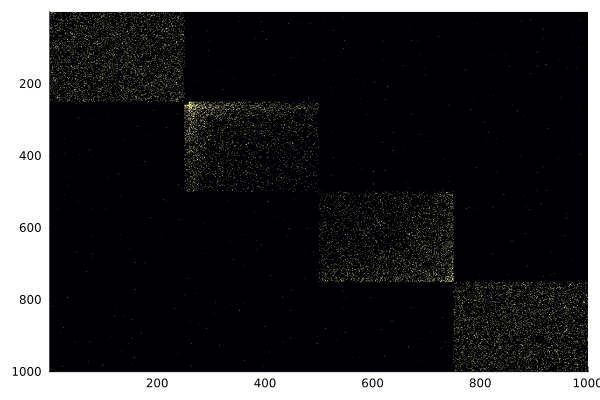

In [15]:
heatmap( ER_BA_SF_WS_Block_matrices[2] , yflip = true , legend = false )

# generate the X and Y variable data

In [16]:
d1 = Dirichlet( [10,10,10] )
c1 = Categorical( [0.5,0.25,0.25] )
d2 = Dirichlet( [20,10,10] )
c2 = Categorical( [0.35,0.35,0.3] )
d3 = Dirichlet( [20,10,20] )
c3 = Categorical( [0.25,0.25,0.5] )
# d1 = Dirichlet( [10,10] )
# c1 = Categorical( [0.5,0.5] )
# d2 = Dirichlet( [20,10] )
# c2 = Categorical( [0.3,0.7] )
# d3 = Dirichlet( [20,10] )
# c3 = Categorical( [0.7,0.3] )
networks_X = Dict()
networks_Y = Dict()
networks_Y_cold = Dict()

for nn in 1:length(NN_set)
    
    NN_tmp = Int( NN_set[nn] / 4 )
    
    xd1 = rand( d1 , NN_tmp )
    xc1 = onehotbatch( rand( c1 , NN_tmp ) , 1:3 )
    x1a = vcat( xd1 , xc1 )'
    xd1 = rand( d1 , NN_tmp )
    xc1 = onehotbatch( rand( c1 , NN_tmp ) , 1:3 )
    x1b = vcat( xd1 , xc1 )'
    xd2 = rand( d2 , NN_tmp )
    xc2 = onehotbatch( rand( c2 , NN_tmp ) , 1:3 )
    x2 = vcat( xd2 , xc2 )'
    xd3 = rand( d3 , NN_tmp )
    xc3 = onehotbatch( rand( c3 , NN_tmp ) , 1:3 )
    x3 = vcat( xd3 , xc3 )'
    xc3 = onehotbatch( rand( c3 , NN_tmp ) , 1:3 )
    x3 = vcat( xd3 , xc3 )'

    networks_X[nn] = vcat( x1a , x1b , x2 , x3 )
    
    y1a = onehotbatch( 1*ones(NN_tmp) , 1:2 )'
    y1b = onehotbatch( 1*ones(NN_tmp) , 1:2 )'
    y2 = onehotbatch( 2*ones(NN_tmp) , 1:2 )'
    y3 = onehotbatch( 2*ones(NN_tmp) , 1:2 )'
    
    networks_Y[nn] = vcat( y1a , y1b , y2 , y3 )
    networks_Y_cold[nn] = vcat(1*ones(NN_tmp),1*ones(NN_tmp),2*ones(NN_tmp),2*ones(NN_tmp))
       
end

In [17]:
Xdim = size(networks_X[1])[2]
Ydim = size(networks_Y[1])[2]

2

In [18]:
epoch_num = 1000

function vanillaSGC(nn,kk,trainInds,testInds)    
    Xdata = networks_X[nn]'
    X_dim = size(Xdata)[1]
    # (ER_BA_SF_WS_Block_matrices[nn] * networks_X[1])' # 6 x 100
    Xdata_Conv = ( (A2S(ER_BA_SF_WS_Block_matrices[nn])^kk) * networks_X[nn] )'

    Ydata = networks_Y_cold[nn]
    Y_dim = length(unique(Ydata)) #Ydim #size(Ydata)[1]
    
    Ydata_1Hot = onehotbatch( Ydata , collect(1:Ydim) )
    
    modelSGC = Chain( Dense( X_dim => Y_dim ) , softmax )
    
    optim = Flux.Adam( 0.01 );
    pars = Flux.params( modelSGC )
    data = Flux.DataLoader( (Xdata_Conv, Ydata_1Hot) ,  batchsize=size(Ydata_1Hot)[2]  ,  shuffle=true ) #batchsize=10 ,
    
    for epoch in 1:epoch_num
        for (x, y) in data
            val, grad = Flux.withgradient(pars) do
                Flux.crossentropy( modelSGC(x)[:,trainInds] , y[:,trainInds] )
            end
            push!(errors, val)
            Flux.update!(optim, pars, grad)
        end
    end
    #display( modelSGC(Xdata_Conv)[:,testInds] )
    tar_inds = findall( x-> x .== 1 , Ydata[testInds] )
    tar_values = modelSGC(Xdata_Conv)[1,tar_inds]
    non_inds = findall( x-> x .== 2 , Ydata[testInds] )
    non_values = modelSGC(Xdata_Conv)[2,non_inds]
    #display( non_values )
    resDict = Dict()
    resDict["training"] = mean( onecold( modelSGC(Xdata_Conv)[:,trainInds], 1:Ydim ) .== Ydata[trainInds] )
    resDict["testing"]  = mean( onecold( modelSGC(Xdata_Conv)[:,testInds], 1:Ydim ) .== Ydata[testInds] )
    resDict["testingTargets"] = tar_values
    resDict["testingNonTargets"] = non_values
    resDict["params"] = pars
    resDict["model"] = modelSGC
    return resDict
end


vanillaSGC (generic function with 1 method)

In [19]:
testing_perc = 0.3
kk = 1
error_dict = Dict()
res_dict = Dict()
errors = []
for nn in 1:length(NN_set)
    stopInd = size(networks_X[nn])[1]
    testInds = Int.(round.( range(1, stop=stopInd, length=Int(round(testing_perc*stopInd))) ))
    trainInds = (1:stopInd)[Not(testInds)]
    errors = []
    res = vanillaSGC(nn,kk,trainInds,testInds)
    error_dict[nn] = errors
    res_dict[nn] = res
end


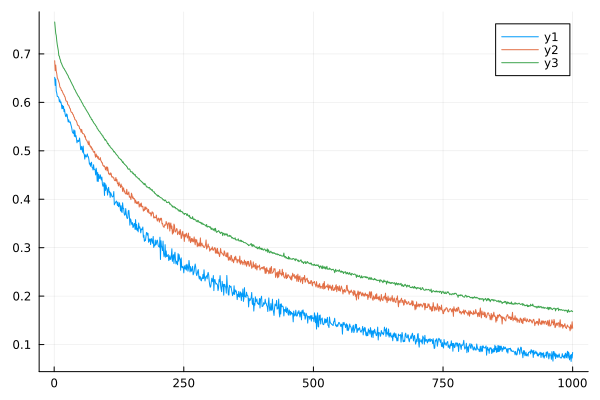

In [20]:
plot(error_dict[1])
plot!(error_dict[2])
plot!(error_dict[3])

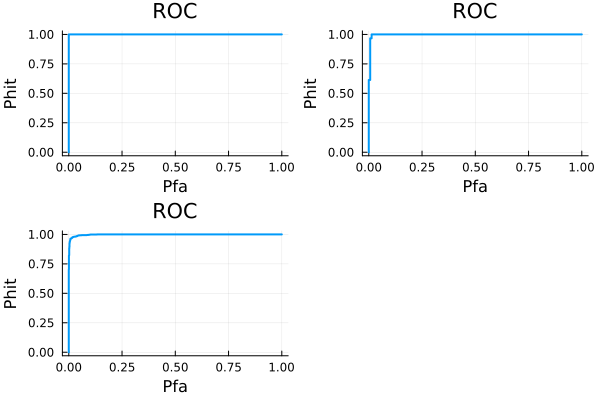

In [21]:
nn=1
plots_tmp = []
for nn in 1:3
    tar = res_dict[nn]["testingTargets"]
    non = res_dict[nn]["testingNonTargets"]
    r = roc(tar, non)
    push!( plots_tmp , plot(r, traditional=true , linewidth = 2) )  
end
plot(plots_tmp...)

In [22]:
[ res_dict[nn]["testing"] for nn in 1:length(res_dict) ]

3-element Vector{Float64}:
 1.0
 0.9766666666666667
 0.9663333333333334

In [23]:
params = res_dict[1]["params"]
println(params)
println(fieldnames(typeof(params)))

Params([Float32[-5.143332 6.1152534 3.098205 4.623113 -3.5143185 -4.6676936; 5.557388 -5.356108 -2.5252507 -4.833494 4.0917487 3.8223634], Float32[0.2634827, -0.2634827]])
(:order, :params)


In [24]:
methodswith(typeof(res_dict[1]["model"]))

0-element Vector{Method}

In [25]:
fieldnames(typeof(res_dict[1]["model"]))

(:layers,)

In [26]:
res_dict[1]["model"].layers

(Dense(6 => 2), NNlib.softmax)

In [27]:
length(res_dict[1]["model"].layers)

2

In [28]:
res_dict[1]["model"].layers[1]

Dense(6 => 2)       # 14 parameters

In [29]:
fieldnames(typeof(res_dict[1]["model"].layers[1]))

(:weight, :bias, :σ)

In [30]:
res_dict[1]["model"].layers[1].weight

2×6 Matrix{Float32}:
 -5.14333   6.11525   3.09821   4.62311  -3.51432  -4.66769
  5.55739  -5.35611  -2.52525  -4.83349   4.09175   3.82236

In [31]:
fieldnames(typeof(res_dict[1]["model"].layers))

(1, 2)

In [32]:
params.params.dict

IdDict{Any, Nothing} with 2 entries:
  Float32[-5.14333 6.11525 … -3.51432 -4.66769; 5.55739 -5.35611 … 4… => nothing
  Float32[0.263483, -0.263483]                                        => nothing

In [33]:
testing_perc = 0.3
kk = 1
error_dict = Dict()
res_dict = Dict()
for nn in 1:length(NN_set)
    stopInd = size(networks_X[nn])[1]
    testInds = Int.(round.( range(1, stop=stopInd, length=Int(round(testing_perc*stopInd))) ))
    trainInds = (1:stopInd)[Not(testInds)]
    errors = []
    res = vanillaSGC(nn,kk,trainInds,testInds)
    error_dict[nn] = errors
    res_dict[nn] = res
end

In [34]:
kk = 1
testing_perc = 0.3


benchmarkDicts_k = Dict()
benchmarkDicts_k["time"] = []
benchmarkDicts_k["memory"] = []
benchmarkDicts_k["gctime"] = []
benchmarkDicts_k["allocs"] = []
for nn in 1:length(NN_set)
    stopInd = size(networks_X[nn])[1]
    testInds = Int.(round.( range(1, stop=stopInd, length=Int(round(testing_perc*stopInd))) ))
    trainInds = (1:stopInd)[Not(testInds)]
    errors = []
    res = vanillaSGC(nn,kk,trainInds,testInds)
    bb = @benchmark vanillaSGC($nn,$kk,$trainInds,$testInds)
    push!(benchmarkDicts_k["time"],mean(bb).time)
    push!(benchmarkDicts_k["memory"],mean(bb).memory)
    push!(benchmarkDicts_k["gctime"],mean(bb).gctime)
    push!(benchmarkDicts_k["allocs"],mean(bb).allocs)
    println(size(networks_X[nn])[1])
end

100
1000
10000


In [35]:
benchmarkDicts_k

Dict{Any, Any} with 4 entries:
  "allocs" => Any[130129, 132135, 154166]
  "time"   => Any[3.26286e7, 1.39362e8, 2.28764e9]
  "memory" => Any[46190096, 359505792, 6340419344]
  "gctime" => Any[2.10474e6, 5.54371e6, 2.59818e8]

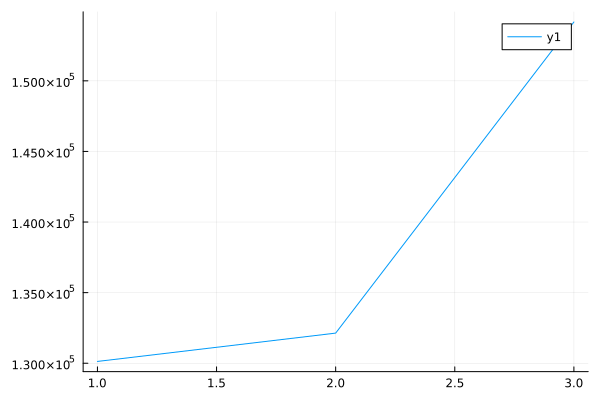

In [36]:
plot(benchmarkDicts_k["allocs"])

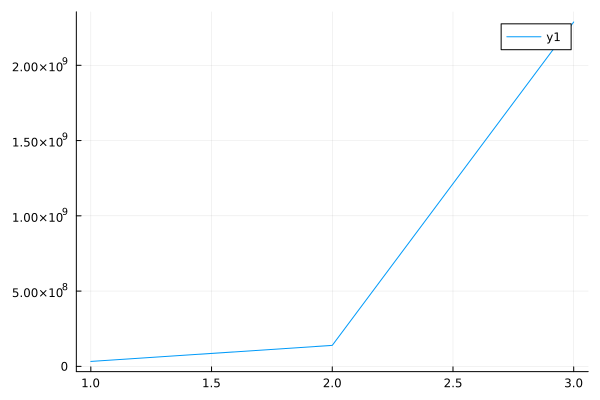

In [37]:
plot(benchmarkDicts_k["time"])

In [38]:
y_label = Flux.onehotbatch([0, 1, 2, 1, 0], 0:2)

3×5 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  ⋅  ⋅  ⋅  1
 ⋅  1  ⋅  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅

In [39]:
y_model = softmax(reshape(-7:7, 3, 5) )

3×5 Matrix{Float64}:
 0.0900306  0.0900306  0.0900306  0.0900306  0.0900306
 0.244728   0.244728   0.244728   0.244728   0.244728
 0.665241   0.665241   0.665241   0.665241   0.665241

In [40]:
Flux.crossentropy(y_model, y_label)

1.6076059644443788

In [41]:
Flux.crossentropy([1,0,0], [1,0,0])

-2.2204460492503128e-16

In [42]:
###################################################################3

In [43]:
EPOCH_NUM = 500

500

In [44]:
nn = 3
kk = 0

Xdata = networks_X[nn]'
X_dim = size(Xdata)[1]
display(X_dim)
# (ER_BA_SF_WS_Block_matrices[nn] * networks_X[1])' # 6 x 100
Xdata_Conv = ( (A2S(ER_BA_SF_WS_Block_matrices[nn])^kk) * networks_X[nn] )'

#display(XdataTest[:,1:10]); display(XdataTest[:,end-10:end])
Ydata = networks_Y_cold[nn]
Y_dim = 3 #size(Ydata)[1]
#println(Ydata[1:10]);println(Ydata[end-10:end]);
println("one hot ?..")
Ydata_1Hot = onehotbatch( Ydata , [1,2,3] )
display(Ydata_1Hot)
#display(YdataTest[:,1:10]); display(YdataTest[:,end-10:end])

modelSGC = Chain( Dense( X_dim => Y_dim ) , softmax )
lossSGC(x,y) = Flux.crossentropy( modelSGC(x) , y )

#optim = Adam( 0.01 );
pars = Flux.params( modelSGC )
optim = Flux.setup(Adam(0.01), modelSGC)
data = Flux.DataLoader( (Xdata_Conv, Ydata_1Hot) , batchsize=10 , shuffle=true )
for epoch in 1:EPOCH_NUM
    #Flux.train!( lossSGC , pars , data , optim )
    Flux.train!( modelSGC,data,optim) do m, x, y
        Flux.crossentropy(m(x), y)
    end
end

mean( onecold( modelSGC(Xdata_Conv), [1,2,3] ) .== Ydata )

6

one hot ?..


3×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  1  1  1  1  1  1  1  1  1  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

0.7968

In [45]:
XdataTest = hcat( repeat( [1,0,0,0,1,0] , 1 , 50 ) , repeat( [0,1,0,0,1,0] , 1 , 25 ) , repeat( [0,0,1,0,1,0] , 1 , 25 ) )
display(XdataTest[:,1:10]); display(XdataTest[:,end-10:end])
Ydata = append!(repeat( [1] , 50 ) , repeat( [2] , 25 ) , repeat( [3] , 25 ) )
println(Ydata[1:10]);println(Ydata[end-10:end]);
YdataTest = onehotbatch( Ydata , [ 1 , 2 , 3 ] )
display(YdataTest[:,1:10]); display(YdataTest[:,end-10:end])

modelTest = Chain( Dense( 6 => 3 ) , softmax )
lossTest(x,y) = Flux.crossentropy(modelTest(x), y)

optimTest =  Flux.setup(Adam(0.01), modelTest) #Adam(0.01);
parsTest = Flux.params(modelTest)
dataTest = Flux.DataLoader( (XdataTest, YdataTest) , batchsize=15 , shuffle=true )
for epoch in 1:EPOCH_NUM
    #Flux.train!( Flux.crossentropy , modelTest , dataTest , optimTest )
    Flux.train!( modelTest,dataTest,optimTest) do m, x, y
        Flux.crossentropy(m(x), y)
    end
end

6×10 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0

6×11 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


3×10 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

3×11 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  1  1  1  1  1  1  1  1  1

In [46]:
XdataTest = hcat( repeat( [1,0,0,0,1,0] , 1 , 50 ) , repeat( [0,1,0,0,1,0] , 1 , 25 ) , repeat( [0,0,1,0,1,0] , 1 , 25 ) )
display(XdataTest[:,1:10]); display(XdataTest[:,end-10:end])
Ydata = append!(repeat( [1] , 50 ) , repeat( [2] , 25 ) , repeat( [3] , 25 ) )
println(Ydata[1:10]);println(Ydata[end-10:end]);
YdataTest = onehotbatch( Ydata , [ 1 , 2 , 3 ] )
display(YdataTest[:,1:10]); display(YdataTest[:,end-10:end])

modelTest = Chain( Dense( 6 => 3 ) , softmax )
lossTest(m,x,y) = Flux.crossentropy(m(x), y)

optimTest =  Flux.setup(Adam(0.01), modelTest) #Adam(0.01);
parsTest = Flux.params(modelTest)
dataTest = Flux.DataLoader( (XdataTest, YdataTest) , batchsize=15 , shuffle=true )
for epoch in 1:EPOCH_NUM
    Flux.train!( lossTest , modelTest , dataTest , optimTest )
    #Flux.train!( modelTest,dataTest,optimTest) do m, x, y
    #    Flux.crossentropy(m(x), y)
    #end
end

6×10 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0

6×11 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


3×10 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  1  1  1  1  1  1  1  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

3×11 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  1  1  1  1  1  1  1  1  1

In [47]:
println(onecold(modelTest(XdataTest),[1,2,3]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [48]:
println(onecold(YdataTest,[1,2,3]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [49]:
mean( onecold(modelTest(XdataTest),[1,2,3]) .== onecold(YdataTest,[1,2,3]) )

1.0

In [50]:
Flux.crossentropy( [0.3,0.6,0.1] , 2 )

8.034767042171937

In [51]:
Flux.crossentropy( [0.8,0.1,0.1] , Flux.onehotbatch( [2] , [1,2,3] ) )

2.3025850929940432

In [52]:
Flux.crossentropy( [0.8,0.1,0.1] , [0,1,0] )

2.3025850929940432

In [53]:

nn = 1
optim = Adam(0.01);
y_D_num = size(networks_Y[nn])[2] # 3
x_feature_num = size(networks_X[nn])[2] # 6
Ydata = networks_Y[nn]'

Xdata = networks_X[1]' # (ER_BA_SF_WS_Block_matrices[nn] * networks_X[1])' # 6 x 100
Xdata

6×100 adjoint(::Matrix{Float64}) with eltype Float64:
 0.275113  0.257627  0.200045  0.351598  …  0.388175  0.389413  0.35442
 0.297624  0.270325  0.512007  0.377672     0.193144  0.23668   0.171623
 0.427263  0.472048  0.287948  0.27073      0.418681  0.373907  0.473957
 0.0       1.0       0.0       1.0          0.0       0.0       0.0
 0.0       0.0       1.0       0.0          0.0       1.0       0.0
 1.0       0.0       0.0       0.0       …  1.0       0.0       1.0

In [54]:
using ChainRulesCore

In [55]:
#this is a basic testing function set which resembles the SGC approach
X = rand(6, 100)
display(X[:,1:10])
truth = []
for col in eachcol(X)
    if( sum(col) < 2.2 )
        append!(truth,1)
    elseif( sum(col) > 3.25)
        append!(truth,3)
    else
        append!(truth,2)
    end
end
display(truth[1:10]')
model = Chain(Dense(6 => 3), softmax)

Y = Flux.onehotbatch( truth , [1,2,3] ) # Flux.onehotbatch( truth , [true, false] )

display(Y[:,1:10])
data = Flux.DataLoader((X, Y), batchsize=15, shuffle=true);

pars = Flux.params(model)
opt = Flux.Adam(0.01)
losses = []
for epoch in 1:EPOCH_NUM
    Flux.train!(pars, data, opt) do x, y
        ChainRulesCore.ignore_derivatives() do
            push!(losses,Flux.crossentropy(model(x), y))
        end
        
        return Flux.crossentropy(model(x), y)
    end
end

predictions = model(X)
display( predictions[:,1:10] )
display( mean( onecold( predictions,[1,2,3] ) .== truth ) )
display( mean( onecold( predictions,[1,2,3] ) .== onecold(Y,[1,2,3]) ) )
display( losses )

6×10 Matrix{Float64}:
 0.0344311  0.545857   0.028339  0.0921993  …  0.207757  0.0167048  0.80772
 0.684084   0.0206443  0.506415  0.202525      0.658643  0.381538   0.751976
 0.985738   0.31398    0.99091   0.507135      0.470307  0.817554   0.190441
 0.374676   0.717272   0.892359  0.368217      0.393204  0.537988   0.789248
 0.0755103  0.599965   0.832012  0.106044      0.417088  0.663984   0.0982737
 0.128881   0.240181   0.461361  0.671467   …  0.336658  0.3848     0.3702

1×10 adjoint(::Vector{Any}) with eltype Any:
 2  2  3  1  2  2  2  2  2  2

3×10 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  ⋅  ⋅  1  1  1  1  1  1
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

3×10 Matrix{Float64}:
 0.493495   0.0123786  0.00237864  …  0.158478   0.114735  0.00164361
 0.469849   0.967854   0.296188       0.783269   0.765422  0.764273
 0.0366556  0.0197671  0.701433       0.0582532  0.119843  0.234083

0.92

0.92

3500-element Vector{Any}:
 1.0241635258882344
 0.9087214735172081
 1.203871864098781
 1.1350621323736723
 1.0996262740242082
 0.9836340093721394
 0.8859682308390274
 0.929614739424782
 1.0083464784062819
 0.9559911067200103
 1.0966505567994809
 0.9646966170175099
 1.014305411067707
 ⋮
 0.3115461353180959
 0.41742662689716936
 0.2408249672386545
 0.2711929452385397
 0.2407625085684674
 0.2509293476029566
 0.2428935789315632
 0.29879755107974143
 0.43459908809340003
 0.3133434308641114
 0.36801279233487383
 0.25255545965747384

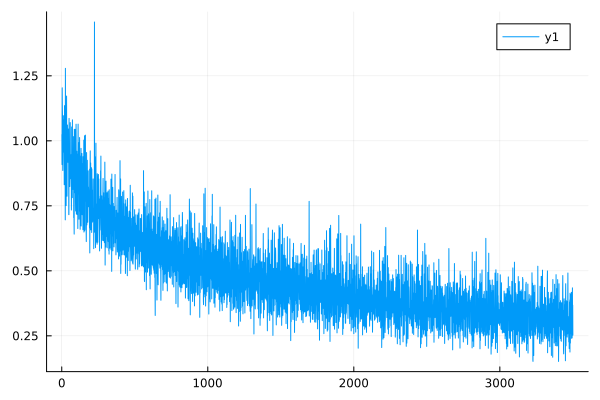

In [56]:
plot( losses )

In [57]:
# resDict = Dict()
# resDict["training"] = mean( onecold( modelSGC(Xdata_Conv)[:,trainInds], 1:Ydim ) .== Ydata[trainInds] )
# resDict["testing"]  = mean( onecold( modelSGC(Xdata_Conv)[:,testInds], 1:Ydim ) .== Ydata[testInds] )
# resDict["testingTargets"] = tar_values
# resDict["testingNonTargets"] = non_values
# resDict["params"] = pars
# resDict["model"] = modelSGC
#resDict = vanillaSGC(nn,kk,trainInds,testInds)    
   
benchmarkDicts_k = Dict()
benchmarkDicts_k["time"] = []
benchmarkDicts_k["memory"] = []
benchmarkDicts_k["gctime"] = []
benchmarkDicts_k["allocs"] = []
for nn in 1:length(NN_set)
    stopInd = size(networks_X[nn])[1]
    testInds = Int.(round.( range(1, stop=stopInd, length=Int(round(testing_perc*stopInd))) ))
    trainInds = (1:stopInd)[Not(testInds)]
    errors = []
    res = vanillaSGC(nn,kk,trainInds,testInds)
    bb = @benchmark vanillaSGC($nn,$kk,$trainInds,$testInds)
    push!(benchmarkDicts_k["time"],mean(bb).time)
    push!(benchmarkDicts_k["memory"],mean(bb).memory)
    push!(benchmarkDicts_k["gctime"],mean(bb).gctime)
    push!(benchmarkDicts_k["allocs"],mean(bb).allocs)
    println(size(networks_X[nn])[1])
end

100
1000
10000


# UNIFORM SEGMENTATION ALGORITHM

- takes the adjacency matrix, feature matrix, and target matrix
- returns a dictionary for each where each dictionary entry is the segmented mask

In [477]:
function UniformSegmentation( segmentation_size , adj , Xdata , Ydata , trainInds , testInds )
    
    n_size = size( adj )[1]
    
    results_segments_dict = Dict()
    
    
    if( n_size < 2*segmentation_size )
        println( "small network" )
    else 
        println( "uniform segmentation" )
        n_segments = collect( range( start=1 , stop=n_size+1 , step=segmentation_size ) )

        ind = 1
        println("n_segments = $(n_segments)")
        for col in 1:length(n_segments)-1
            for row in 1:length(n_segments)-1
                result_dict = Dict()
                                
                result_dict["adj"] = adj[ n_segments[row]:n_segments[row+1]-1 , n_segments[col]:n_segments[col+1]-1 ] # adj_dict[ind]
                result_dict["Xdata"] = Xdata[ n_segments[col]:n_segments[col+1]-1 , : ] # Xdata_dict[ind]
                result_dict["Ydata"] = Ydata[ n_segments[row]:n_segments[row+1]-1 , : ] # Ydata_dict[ind]
                
                tmp_inds = []
                [ if(rr in trainInds) push!(tmp_inds,rr) end for rr in n_segments[row]:n_segments[row+1]-1 ]
                tmp_inds .-= n_segments[row] .- 1
                result_dict["trainInds"] = tmp_inds # trainInds_dict[ind]
                
                tmp_inds = []
                [ if(rr in testInds) push!(tmp_inds,rr) end for rr in n_segments[row]:n_segments[row+1]-1 ]
                tmp_inds .-= n_segments[row] .- 1
                result_dict["testInds"] = tmp_inds # testInds_dict[ind]
                
                results_segments_dict[ind] = result_dict
                ind += 1
            end
        end
        return results_segments_dict # [ adj_dict , Xdata_dict , Ydata_dict , trainInds_dict , testInds_dict ]
    end    
    
end 

UniformSegmentation (generic function with 3 methods)

In [478]:
nn = 1
k = 3
testing_perc = 0.6

adj = ER_BA_SF_WS_Block_matrices[nn]
display( size(adj) )
Xdata = networks_X[nn]
println(size(Xdata))
Ydata = networks_Y_cold[nn]
println(size(Ydata))

stopInd = size(networks_X[nn])[1]
testInds = Int.(round.( range(1, stop=stopInd, length=Int(round(testing_perc*stopInd))) ))
trainInds = (1:stopInd)[Not(testInds)]

segmentation = 50
results_dict = UniformSegmentation( segmentation , adj , Xdata , Ydata , trainInds , testInds )

(100, 100)

(100, 6)
(100,)
uniform segmentation
n_segments = [1, 51, 101]


Dict{Any, Any} with 4 entries:
  4 => Dict{Any, Any}("trainInds"=>Any[2, 4, 7, 9, 12, 14, 17, 19, 22, 24, 26, …
  2 => Dict{Any, Any}("trainInds"=>Any[2, 4, 7, 9, 12, 14, 17, 19, 22, 24, 26, …
  3 => Dict{Any, Any}("trainInds"=>Any[2, 5, 7, 10, 12, 15, 17, 20, 22, 25, 27,…
  1 => Dict{Any, Any}("trainInds"=>Any[2, 5, 7, 10, 12, 15, 17, 20, 22, 25, 27,…

In [479]:
println( size(results_dict[4]["Ydata"]) )

(50, 1)


In [480]:
println( size(results_dict[4]["adj"]) )

(50, 50)


In [481]:
println( size(results_dict[2]["trainInds"]) )

(20,)


In [482]:
results_dict[2]["testInds"]

30-element Vector{Any}:
  1
  3
  5
  6
  8
 10
 11
 13
 15
 16
 18
 20
 21
  ⋮
 32
 33
 35
 37
 38
 40
 42
 43
 45
 47
 48
 50

In [483]:
results_dict[2]["trainInds"]

20-element Vector{Any}:
  2
  4
  7
  9
 12
 14
 17
 19
 22
 24
 26
 29
 31
 34
 36
 39
 41
 44
 46
 49

In [436]:
size( results_dict[1]["Xdata"] )

(50, 6)

# TESTING 

In [136]:
function vanillaSGC_test( adj , k , Xdata , Ydata , trainInds , testInds , targets , target_val )
    errors = []
    X_dim = size(Xdata)[2]
    # (ER_BA_SF_WS_Block_matrices[nn] * networks_X[1])' # 6 x 100
    
    Xdata_Conv = ( (A2S(adj)^k) * Xdata )'
    
    Y_dim = length(unique(Ydata)) #Ydim #size(Ydata)[1]
    
    Ydata_1Hot = onehotbatch( Ydata , targets )
    
    modelSGC = Chain( Dense( X_dim => Y_dim ) , softmax )
    
    optim = Flux.Adam( 0.01 )
    pars = Flux.params( modelSGC )
    data = Flux.DataLoader( (Xdata_Conv, Ydata_1Hot) , batchsize=size(Ydata_1Hot)[2] , shuffle=true )
    
    for epoch in 1:epoch_num
        for (x, y) in data
            val, grad = Flux.withgradient(pars) do
                Flux.crossentropy( modelSGC(x)[:,trainInds] , y[:,trainInds] )
            end
            push!(errors, val)
            Flux.update!(optim, pars, grad)
        end
    end
    
    #display( modelSGC(Xdata_Conv)[:,testInds] )
    tar_inds = findall( x-> x .== target_val , Ydata[testInds] )
    tar_values = modelSGC(Xdata_Conv)[1,tar_inds]
    non_inds = findall( x-> x .!= target_val , Ydata[testInds] )
    non_values = modelSGC(Xdata_Conv)[2,non_inds]
    #display( non_values )
    resDict = Dict()
    resDict["errors"] = errors
    resDict["training"] = mean( onecold( modelSGC(Xdata_Conv)[:,trainInds], targets ) .== Ydata[trainInds] )
    resDict["testing"]  = mean( onecold( modelSGC(Xdata_Conv)[:,testInds], targets) .== Ydata[testInds] )
    resDict["testingTargets"] = tar_values
    resDict["testingNonTargets"] = non_values
    resDict["params"] = pars
    resDict["model"] = modelSGC
    return resDict
end

vanillaSGC_test (generic function with 1 method)

In [434]:
nn = 1
k = 3
testing_perc = 0.3

adj = ER_BA_SF_WS_Block_matrices[nn]
display( size(adj) )
Xdata = networks_X[nn]
println("size Xdata = ", size(Xdata) )
Ydata = networks_Y_cold[nn]
println("size Ydata = ", size(Ydata) )

stopInd = size(networks_X[nn])[1]
testInds = Int.(round.( range(1, stop=stopInd, length=Int(round(testing_perc*stopInd))) ))
trainInds = (1:stopInd)[Not(testInds)]

targets = collect(1:2)

target_val = 1

results = vanillaSGC_test( adj , k , Xdata , Ydata , trainInds , testInds , targets , target_val )

(100, 100)

size Xdata = (100, 6)
size Ydata = (100,)
ok1
ok2
ok3
ok4


Dict{Any, Any} with 7 entries:
  "testingNonTargets" => [0.335346, 0.231197, 0.223799, 0.529705, 0.0616299, 0.…
  "errors"            => Any[0.71262, 0.693369, 0.708543, 0.672789, 0.688358, 0…
  "model"             => Chain(Dense(6 => 2), softmax)
  "testing"           => 0.833333
  "testingTargets"    => [0.651287, 0.888411, 0.97533, 0.881878, 0.301735, 0.61…
  "params"            => Params([Float32[-5.15458 4.71061 … -0.481357 -0.362644…
  "training"          => 0.828571

0.8285714285714286
0.8333333333333334


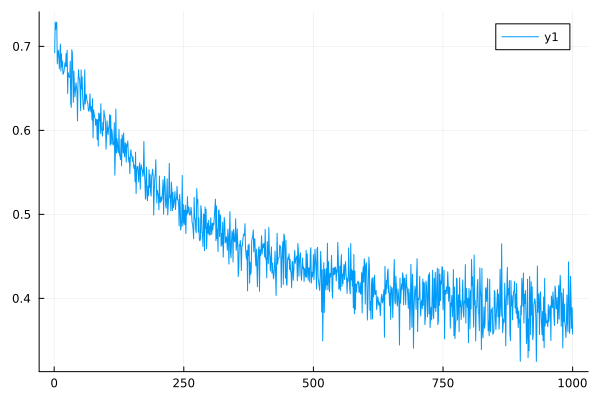

In [74]:
println( results["training"] )
println( results["testing"] )
plot( results["errors"] )

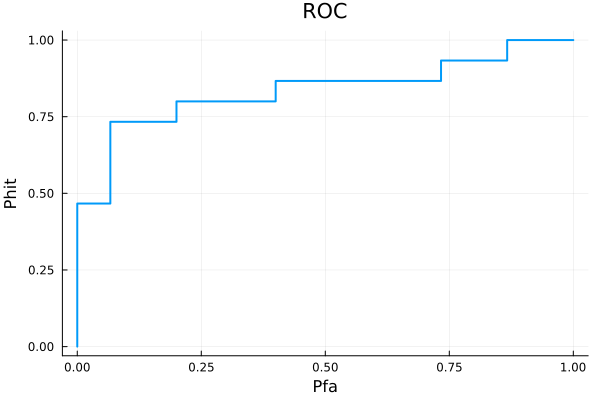

In [75]:
tar = results["testingTargets"]
non = results["testingNonTargets"]
r = roc(tar, non)
plot(r, traditional=true , linewidth = 2)


In [484]:
function vanillaSegmentation_test( adj , k , Xdata , Ydata , trainInds , testInds , targets , target_val )
    
    segmentation = 50
    results_dict = UniformSegmentation( segmentation , adj , Xdata , Ydata , trainInds , testInds )
    println("ok1")
    errors = []
    X_dim = size(Xdata)[2]
    # (ER_BA_SF_WS_Block_matrices[nn] * networks_X[1])' # 6 x 100
        
    Y_dim = length(unique(Ydata)) #Ydim #size(Ydata)[1]
        
    modelSGC = Chain( Dense( X_dim => Y_dim ) , softmax )
    
    println("ok2")
    
    optim = Flux.Adam( 0.01 )
    pars = Flux.params( modelSGC )
    
    for epoch2 in 1:10
        for r_ind in 1:length(results_dict)
            tmp = size(results_dict[r_ind]["adj"])
            println("size results_dict[r_ind][adj] = $(tmp)")
            Xdata_Conv = ( (A2S(results_dict[r_ind]["adj"])^kk) * results_dict[r_ind]["Xdata"] )'
            println("size of Xdata_Conv = $(size(Xdata_Conv))")
            tmp = size( modelSGC(Xdata_Conv) )
            println(" size of modelSGC(Xdata_Conv) = $(tmp)")
            Ydata_1Hot = onehotbatch( results_dict[r_ind]["Ydata"] , targets )[:,:]
            tmp = size(results_dict[r_ind]["Ydata"])
            println("size of ydata = $(tmp)")
            println("size of Ydata_1Hot = $(size(Ydata_1Hot))")
            
            data = Flux.DataLoader( (Xdata_Conv, Ydata_1Hot) , batchsize=size(Ydata_1Hot)[2] , shuffle=true )
            trainInds = results_dict[r_ind]["trainInds"]
            testInds = results_dict[r_ind]["testInds"]
            println("size of trainInds = $(size(results_dict[r_ind]["trainInds"])) , size of testInds = $(size(results_dict[r_ind]["testInds"])) ")
            println(trainInds)
            println(testInds)
            println("r_ind = $(r_ind)")
            for epoch in 1:20
                println("in epoch")
                for (x, y) in data
                    println("data size = $(size(x)), $(size(y))")
                    
                    tmp = modelSGC(x)
                    println("tmp ok")
                    tmp2 = modelSGC(x)[:,trainInds]
                    println("tmp2 size = $(size(tmp2))")
                    val, grad = Flux.withgradient(pars) do
                        Flux.crossentropy( modelSGC(x)[:,trainInds] , y[:,trainInds] )
                    end
                    push!(errors, val)
                    Flux.update!(optim, pars, grad)
                end
            end
            println("ok5b")
        end
    end
    println("ok6")
    #display( modelSGC(Xdata_Conv)[:,testInds] )
#     tar_inds = findall( x-> x .== target_val , Ydata[testInds] )
#     tar_values = modelSGC(Xdata_Conv)[1,tar_inds]
#     non_inds = findall( x-> x .!= target_val , Ydata[testInds] )
#     non_values = modelSGC(Xdata_Conv)[2,non_inds]
    #display( non_values )
    println("7")
    resDict = Dict()
    println("8")
    resDict["errors"] = errors
    println("9")
#     resDict["training"] = mean( onecold( modelSGC(Xdata_Conv)[:,trainInds], targets ) .== Ydata[trainInds] )
#     resDict["testing"]  = mean( onecold( modelSGC(Xdata_Conv)[:,testInds], targets) .== Ydata[testInds] )
#     resDict["testingTargets"] = tar_values
#     resDict["testingNonTargets"] = non_values
    resDict["params"] = pars
    resDict["model"] = modelSGC
    println("10")
    return resDict
end

vanillaSegmentation_test (generic function with 1 method)

In [485]:
results = vanillaSegmentation_test( adj , k , Xdata , Ydata , trainInds , testInds , targets , target_val )

uniform segmentation
n_segments = [1, 51, 101]
ok1
ok2
size results_dict[r_ind][adj] = (50, 50)
size of Xdata_Conv = (6, 50)
 size of modelSGC(Xdata_Conv) = (2, 50)
size of ydata = (50, 1)
size of Ydata_1Hot = (2, 50)
size of trainInds = (20,) , size of testInds = (30,) 
Any[2, 5, 7, 10, 12, 15, 17, 20, 22, 25, 27, 29, 32, 34, 37, 39, 42, 44, 47, 49]
Any[1, 3, 4, 6, 8, 9, 11, 13, 14, 16, 18, 19, 21, 23, 24, 26, 28, 30, 31, 33, 35, 36, 38, 40, 41, 43, 45, 46, 48, 50]
r_ind = 1
in epoch
data size = (6, 50), (2, 50)
tmp ok
tmp2 size = (2, 20)
in epoch
data size = (6, 50), (2, 50)
tmp ok
tmp2 size = (2, 20)
in epoch
data size = (6, 50), (2, 50)
tmp ok
tmp2 size = (2, 20)
in epoch
data size = (6, 50), (2, 50)
tmp ok
tmp2 size = (2, 20)
in epoch
data size = (6, 50), (2, 50)
tmp ok
tmp2 size = (2, 20)
in epoch
data size = (6, 50), (2, 50)
tmp ok
tmp2 size = (2, 20)
in epoch
data size = (6, 50), (2, 50)
tmp ok
tmp2 size = (2, 20)
in epoch
data size = (6, 50), (2, 50)
tmp ok
tmp2 size = (2, 20)

Dict{Any, Any} with 3 entries:
  "errors" => Any[0.532827, 0.476344, 0.420681, 0.494637, 0.404873, 0.352203, 0…
  "model"  => Chain(Dense(6 => 2), softmax)
  "params" => Params([Float32[-0.457924 -0.678837 … 1.0283 0.0264307; -0.364344…

In [421]:
size( Xdata )

(100, 6)

In [451]:
rr = rand(2,50,1)
size( rr[:,:,1] )

(2, 50)

## Using the segmentation

In [62]:
include("teddy_test_function_01_16_2023.jl")

my_function (generic function with 1 method)

In [63]:
adj = rand( 50 , 50 );
xx = rand( 50 , 3 );
yy = round.( rand( 50 , 1 ) .+ 1 );
par = 2

2

In [64]:
my_function( adj , xx , yy , par );

Accuracy by training all data: 54.0%, k = 3


In [65]:
nn=1
Xdata = networks_X[nn];
display( size( Xdata ) )
Xdata2 = Xdata[shuffle(1:size(Xdata)[1]), :]
Ydata = networks_Y_cold[nn];
Adj = ER_BA_SF_WS_Block_matrices[nn];

(100, 6)

In [66]:
my_function( Adj , Xdata , Ydata , 1 );

Accuracy by training all data: 100.0%, k = 3


In [67]:
my_function( Adj , Xdata , Ydata , 2 );

Accuracy by training all data: 100.0%, k = 3


In [68]:
my_function( Adj , Xdata , Ydata , 3 );

Accuracy by training all data: 100.0%, k = 3
SX: (6, 90)
weight: (2, 6)


In [69]:
[ my_function( Adj , Xdata , Ydata , pp ) for pp in 1:3 ]

Accuracy by training all data: 100.0%, k = 3
Accuracy by training all data: 100.0%, k = 3
Accuracy by training all data: 100.0%, k = 3
SX: (6, 90)
weight: (2, 6)


3-element Vector{Vector{Int64}}:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [1, 2, 2, 1, 2, 2, 2, 2, 1, 1  …  2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [70]:
[ my_function( Adj , Xdata2 , Ydata , pp ) for pp in 1:3 ]

Accuracy by training all data: 100.0%, k = 3
Accuracy by training all data: 100.0%, k = 3
Accuracy by training all data: 100.0%, k = 3
SX: (6, 90)
weight: (2, 6)


3-element Vector{Vector{Int64}}:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 [2, 1, 1, 1, 1, 1, 2, 1, 1, 1  …  2, 2, 1, 1, 1, 1, 1, 1, 1, 2]
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [71]:
@benchmark A2S(AA)

BenchmarkTools.Trial: 20 samples with 1 evaluation.
 Range (min … max):  143.216 ms … 167.166 ms  ┊ GC (min … max): 3.54% … 3.39%
 Time  (median):     155.308 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   155.732 ms ±   5.645 ms  ┊ GC (mean ± σ):  0.97% ± 1.50%

  ▁         ▁      ▁  ▁ ▁ ▁▁▁  ▁▁█     ▁▁   ▁ ▁▁ ▁ ▁          ▁  
  █▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁█▁█▁███▁▁███▁▁▁▁▁██▁▁▁█▁██▁█▁█▁▁▁▁▁▁▁▁▁▁█ ▁
  143 ms           Histogram: frequency by time          167 ms <

 Memory estimate: 199.32 MiB, allocs estimate: 40.